### Importing libraries and setting seeds

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Dense, Flatten, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
import pickle

# Set all seeds
np.random.seed(42)                        
tf.random.set_seed(42)                    
import random
random.seed(42)

# Force TensorFlow to use deterministic algorithms
tf.config.experimental.enable_op_determinism()

### Loading and preprocessing Fashion MNIST

Training set shape: (50000, 28, 28, 1)
Validation set shape: (10000, 28, 28, 1)
Test set shape: (10000, 28, 28, 1)
Data type: float64

Min value: 0.0
Max value: 1.0
Mean value: 0.2862758283313326
Standard deviation: 0.3531853296234766

Unique labels: [0 1 2 3 4 5 6 7 8 9]
Label distribution in training set:
Class 0: Train: 5000, Val: 1000, Test: 1000 images
Class 1: Train: 5000, Val: 1000, Test: 1000 images
Class 2: Train: 5000, Val: 1000, Test: 1000 images
Class 3: Train: 5000, Val: 1000, Test: 1000 images
Class 4: Train: 5000, Val: 1000, Test: 1000 images
Class 5: Train: 5000, Val: 1000, Test: 1000 images
Class 6: Train: 5000, Val: 1000, Test: 1000 images
Class 7: Train: 5000, Val: 1000, Test: 1000 images
Class 8: Train: 5000, Val: 1000, Test: 1000 images
Class 9: Train: 5000, Val: 1000, Test: 1000 images

Sample image:


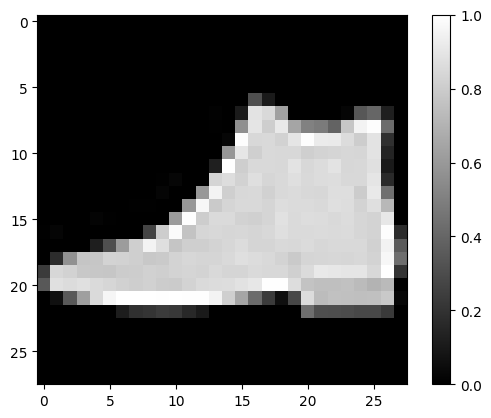

In [3]:
# Import the dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalize pixel values to [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# Add channel dimension
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Split x_train into train and validation sets while maintaining class distribution
x_train, x_val, y_train, y_val = train_test_split(
    x_train,
    y_train,
    test_size=1/6,
    random_state=42,
    stratify=y_train
)

# Display information about the dataset
print("Training set shape:", x_train.shape)
print("Validation set shape:", x_val.shape)
print("Test set shape:", x_test.shape)
print("Data type:", x_train.dtype)

print("\nMin value:", x_train.min())
print("Max value:", x_train.max())
print("Mean value:", x_train.mean())
print("Standard deviation:", x_train.std())

print("\nUnique labels:", np.unique(y_train))
print("Label distribution in training set:")
for i in range(10):
    print(f"Class {i}: Train: {np.sum(y_train == i)}, "
          f"Val: {np.sum(y_val == i)}, "
          f"Test: {np.sum(y_test == i)} images")

print("\nSample image:")
plt.imshow(x_train[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

### Defining model architecture
We want to see how the use of ReLU and Adam improves model performance compared to tanh and SGD used in the original LeNet-5 paper. 

In [17]:
def create_model(activation='tanh', 
                 optimizer='sgd', 
                 learning_rate=0.01, 
                 input_shape=(28, 28, 1)):
    """
    Function to create and compile the LeNet-5 model.

    Returns:
    --------
    model : compiled keras.Model
    """
    # Create model architecture
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(filters=6, kernel_size=5, activation=activation),
        AveragePooling2D(pool_size=2, strides=2),
        Conv2D(filters=16, kernel_size=5, activation=activation),
        AveragePooling2D(pool_size=2, strides=2),
        Conv2D(filters=120, kernel_size=4, activation=activation),
        Flatten(),
        Dense(84, activation=activation),
        Dense(10, activation='softmax')
    ])
    
    # Configure optimizer
    if optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate, momentum=0.9)
    else:  # adam
        opt = Adam(learning_rate=learning_rate)
        
    # Compile model
    model.compile(
        optimizer=opt,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [19]:
# Grid Search for LeNet5 with both configurations

configurations = [
    {
        'name': 'LeNet5 (tanh+SGD)',
        'activation': 'tanh',
        'optimizer': 'sgd',
        'learning_rate': 0.01  # Higher initial LR for SGD
    },
    {
        'name': 'LeNet5 (ReLU+Adam)',
        'activation': 'relu',
        'optimizer': 'adam',
        'learning_rate': 0.001  # Lower initial LR for Adam
    }
]

# Define parameter grid
param_grid = {
    'batch_size': [32, 64, 128, 256]
}

results = {}

for config in configurations:
    print(f"\n=== Grid Search for {config['name']} ===")
    
    # Define callbacks for GridSearchCV
    callbacks_gridsearch = [
        EarlyStopping(
            monitor='loss',
            patience=5,
            restore_best_weights=True,
            verbose=0,
            min_delta=0.0001,
            mode='min'
        ),
        ReduceLROnPlateau(
            monitor='loss',
            factor=0.2,
            patience=3,
            min_lr=1e-6,
            verbose=0
        )
    ]
    
    # Create the KerasClassifier
    model_gs = KerasClassifier(
        model=lambda: create_model(
            activation=config['activation'],
            optimizer=config['optimizer'],
            learning_rate=config['learning_rate']
        ),
        epochs=100,
        verbose=0,  # Minimize output during GridSearchCV
        fit__callbacks=callbacks_gridsearch  # Pass callbacks correctly
    )
    
    # Create and run GridSearchCV
    grid = GridSearchCV(
        estimator=model_gs,
        param_grid=param_grid,
        cv=3,
        verbose=2,
        n_jobs=1
    )
    
    # Fit the grid search
    grid_result = grid.fit(x_train, y_train)
    
    # Store results
    results[config['name']] = {
        'best_params': grid_result.best_params_,
        'best_score': grid_result.best_score_,
        'cv_results': grid_result.cv_results_
    }
    
    # Print results
    print(f"\nBest parameters found:", grid_result.best_params_)
    print(f"Best cross-validation score: {grid_result.best_score_:.4f}")
    
    # Get detailed results for all combinations
    print("\nDetailed results for all batch sizes:")
    for mean_score, std_score, params in zip(
        grid_result.cv_results_['mean_test_score'],
        grid_result.cv_results_['std_test_score'],
        grid_result.cv_results_['params']
    ):
        print(f"\nBatch size: {params['batch_size']}")
        print(f"Mean validation score: {mean_score:.4f} (+/- {std_score * 2:.4f})")
    
# Print final comparison
print("\n=== Final Comparison ===")
for name, result in results.items():
    print(f"\n{name}:")
    print(f"Best batch size: {result['best_params']['batch_size']}")
    print(f"Best score: {result['best_score']:.4f}")


=== Grid Search for LeNet5 (tanh+SGD) ===
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ......................................batch_size=32; total time=  58.1s
[CV] END ......................................batch_size=32; total time= 2.6min
[CV] END ......................................batch_size=32; total time= 1.9min
[CV] END ......................................batch_size=64; total time= 1.4min
[CV] END ......................................batch_size=64; total time= 1.7min
[CV] END ......................................batch_size=64; total time= 1.8min
[CV] END .....................................batch_size=128; total time= 1.4min
[CV] END .....................................batch_size=128; total time= 1.4min
[CV] END .....................................batch_size=128; total time= 1.4min
[CV] END .....................................batch_size=256; total time= 1.2min
[CV] END .....................................batch_size=256; total time= 1.2min
[CV] E

### Final training runs with best batch size parameters

In [20]:
for config in configurations:
    print(f"\n=== Final Training for {config['name']} ===")
    
    # Create the model
    model = create_model(
        activation=config['activation'],
        optimizer=config['optimizer'],
        learning_rate=config['learning_rate']
    )
    
    # Get the best batch size from GridSearchCV
    best_batch_size = results[config['name']]['best_params']['batch_size']
    
    # Define callbacks for final training
    callbacks_final = [
        EarlyStopping(
            monitor='val_loss',  # Monitor validation loss
            patience=5,
            restore_best_weights=True,
            verbose=1,
            min_delta=0.0001,
            mode='min'
        ),
        ReduceLROnPlateau(
            monitor='val_loss',  # Monitor validation loss
            factor=0.5,
            patience=3,
            min_lr=1e-6,
            verbose=1
        )
    ]
    
    # Train the model
    history = model.fit(
        x_train,
        y_train,
        batch_size=best_batch_size,
        epochs=100,
        callbacks=callbacks_final,
        validation_data=(x_val, y_val),
        verbose=1  # Detailed output during final training
    )
    
    # Save the weights and history
    filename_prefix = f"lenet5_{config['activation']}_{config['optimizer']}"
    model.save_weights(f'results/{filename_prefix}_final.weights.h5')
    with open(f'results/{filename_prefix}_final_history.pkl', 'wb') as file:
        pickle.dump(history.history, file)


=== Final Training for LeNet5 (tanh+SGD) ===
Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4812 - loss: 1.4802 - val_accuracy: 0.7623 - val_loss: 0.6353 - learning_rate: 0.0100
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7700 - loss: 0.6190 - val_accuracy: 0.8036 - val_loss: 0.5334 - learning_rate: 0.0100
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8028 - loss: 0.5358 - val_accuracy: 0.8231 - val_loss: 0.4838 - learning_rate: 0.0100
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8214 - loss: 0.4905 - val_accuracy: 0.8338 - val_loss: 0.4522 - learning_rate: 0.0100
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8330 - loss: 0.4595 - val_accuracy: 0.8442 - val_loss: 0.4285 - learning_rate: 0.0100
Epoch 6/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8439 - loss: 0.4354 - val_accuracy: 0.8526 - val_loss: 0.4094 - learning_rate: 0.0100
Epoch 7/100
196/196 ━━━━━━━━━━━━━━━

### Visualizing training history

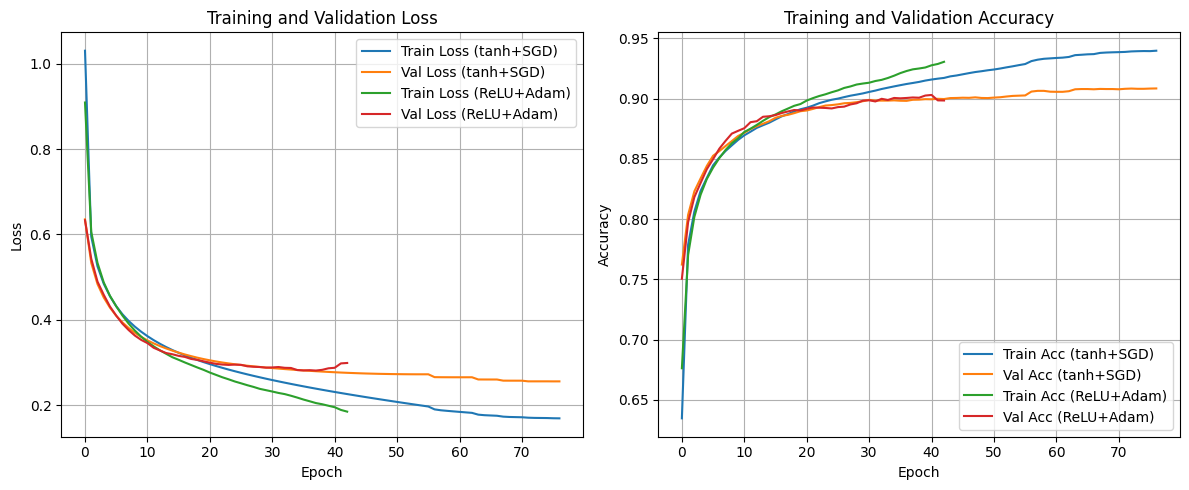

In [21]:
# Load the training histories for both models
with open('results/lenet5_tanh_sgd_final_history.pkl', 'rb') as file:
    history_tanh = pickle.load(file)

with open('results/lenet5_relu_adam_final_history.pkl', 'rb') as file:
    history_relu = pickle.load(file)

# Plot the training histories
plt.figure(figsize=(12, 5))

# Plot training & validation loss for both models
plt.subplot(1, 2, 1)
plt.plot(history_tanh['loss'], label='Train Loss (tanh+SGD)')
plt.plot(history_tanh['val_loss'], label='Val Loss (tanh+SGD)')
plt.plot(history_relu['loss'], label='Train Loss (ReLU+Adam)')
plt.plot(history_relu['val_loss'], label='Val Loss (ReLU+Adam)')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot training & validation accuracy for both models
plt.subplot(1, 2, 2)
plt.plot(history_tanh['accuracy'], label='Train Acc (tanh+SGD)')
plt.plot(history_tanh['val_accuracy'], label='Val Acc (tanh+SGD)')
plt.plot(history_relu['accuracy'], label='Train Acc (ReLU+Adam)')
plt.plot(history_relu['val_accuracy'], label='Val Acc (ReLU+Adam)')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

### Evaluating on the test set

In [ ]:
# Create models with the same architectures and correct parameters
model_tanh = create_model(
    activation='tanh',
    optimizer='sgd',
    learning_rate=0.01,  
    input_shape=(28, 28, 1)
)

model_relu = create_model(
    activation='relu',
    optimizer='adam',
    learning_rate=0.001,  
    input_shape=(28, 28, 1)
)

# Load the saved weights (ensure file names match those used during saving)
model_tanh.load_weights('results/lenet5_tanh_sgd_final.weights.h5')
model_relu.load_weights('results/lenet5_relu_adam_final.weights.h5')

# Evaluate both models on the test set
print("Evaluating LeNet5 with tanh activation and SGD optimizer:")
test_loss_tanh, test_accuracy_tanh = model_tanh.evaluate(x_test, y_test, verbose=1)

print("\nEvaluating LeNet5 with ReLU activation and Adam optimizer:")
test_loss_relu, test_accuracy_relu = model_relu.evaluate(x_test, y_test, verbose=1)

# Print comparison summary
print("\n=== Model Comparison Summary ===")
print(f"LeNet5 (tanh + SGD):")
print(f"- Test Loss: {test_loss_tanh:.4f}")
print(f"- Test Accuracy: {test_accuracy_tanh:.4f}")

print(f"\nLeNet5 (ReLU + Adam):")
print(f"- Test Loss: {test_loss_relu:.4f}")
print(f"- Test Accuracy: {test_accuracy_relu:.4f}")

# Calculate the percentage improvement in test accuracy
improvement = ((test_accuracy_relu - test_accuracy_tanh) / test_accuracy_tanh) * 100
print(f"\nImprovement with ReLU + Adam over tanh + SGD: {improvement:.2f}%")

/home/dkat/courses/computer-vision/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/dkat/courses/computer-vision/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Evaluating LeNet5 with tanh activation and SGD optimizer:
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8946 - loss: 0.2867

Evaluating LeNet5 with ReLU activation and Adam optimizer:
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8950 - loss: 0.3027

=== Model Comparison Summary ===
LeNet5 (tanh + SGD):
- Test Loss: 0.2860
- Test Accuracy: 0.8976

LeNet5 (ReLU + Adam):
- Test Loss: 0.3095
- Test Accuracy: 0.8924

Improvement with ReLU + Adam over tanh + SGD: -0.58%
